<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S11_Assignment(CLR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   all.py	       execute.py    __pycache__
AlbTrainTransforms.py  DataLoaders.py  Gradcam.py    resNet.py
albumentations.py      displayData.py  LR_Finder.py  rohan_library.py


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
# import AlbTrainTransforms
import LR_Finder as lrf

displayData-1.11 loaded ...


  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [5]:
from albumentations import Compose, RandomCrop, Normalize, Resize, Rotate, Cutout, PadIfNeeded, RandomCrop, Flip
from albumentations.pytorch import ToTensor
import numpy as np


class train_transforms():
  """
  Transformations Applied:-

  1. PadIfNeeded: To pad the image by 4 pixels on each side, making the input image size = 40x40
  2. RandomCrop: To crop out 32x32 portion of the input image(40x400)
  3. Flip: Flip the input image horizontally or vertically at p = 0.50
  4. Cutout: Blocking a 8x8 portion of the input image at p = 1.0
  5. Normalize: Simply the normalizing the transformed image
  6. ToTensor: Converting the normalized image to Tensor
  """

  def __init__(self):
        self.albTrainTransforms = Compose([ 
            PadIfNeeded(min_height = 36, min_width = 36, border_mode = 0, p = 1.0),
            RandomCrop(height = 32, width = 32, p = 1.0),
            Flip(p=0.5),
            Cutout(num_holes = 1, max_h_size = 8, max_w_size = 8, p = 1.0),
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ToTensor()
        ])

        print("REQUIRED LIBRARIES LOADED...")

  def __call__(self, img):
        img = np.array(img)
        img = self.albTrainTransforms(image=img)['image']
        return img

albTrain = train_transforms()
albTest = AlbTestTransforms.test_transforms()

REQUIRED LIBRARIES LOADED...
AlbTestTransforms-1.11 loaded ...


**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [7]:
dl = loader.DataLoaders(batch_size=512)
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


DataLoaders-1.11 loaded ...


In [8]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


**Displaying Random Images**

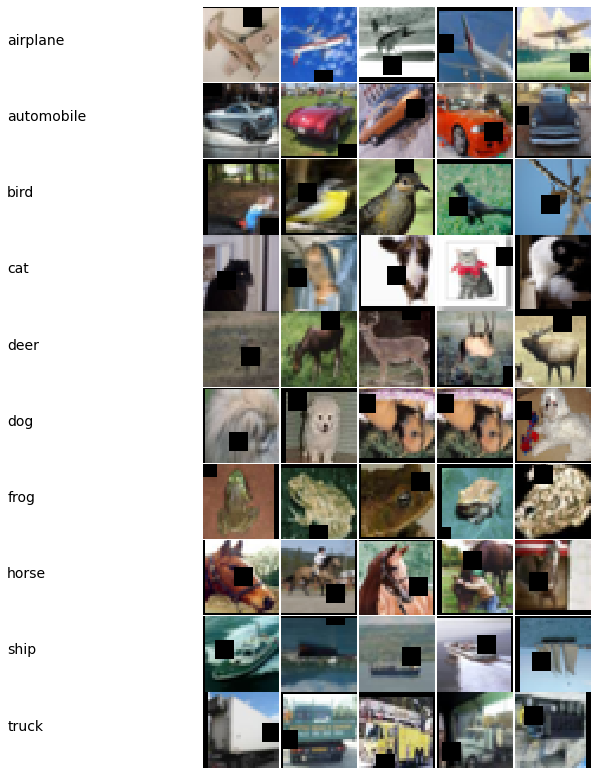

In [21]:
display.class_images(trainLoader)


**CustomNet**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic Block

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        # Residual Block
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                                stride = stride, padding = 1, bias = False)
        self.bn1 = nn.Sequential(nn.BatchNorm2d(planes))
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, 
                                stride = stride, padding = 1, bias=False)
        self.bn2 = nn.Sequential(nn.BatchNorm2d(planes))

        # # Shortcut
        # self.shortcut = nn.Sequential()
        # if stride != 1 or in_planes != self.expansion*planes:
        #     self.shortcut = nn.Sequential(
        #         nn.Conv2d(in_planes, self.expansion*planes,
        #                   kernel_size=3,padding=1, bias=False),
        #         nn.BatchNorm2d(self.expansion*planes))
        #         # nn.MaxPool2d((2,2)))
        #     # self.shortcut = nn.Sequential(nn.MaxPool2d((2,2)))
          
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # print("shape of out x", out.shape)
        # print("shape of shortcut x", self.shortcut(x).shape)
        out = out + x
        out = F.relu(out)
        return out

# customNet Class
class customNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(customNet,self).__init__()
        self.in_planes = 128

        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False))
        self.bn1 = nn.Sequential(nn.BatchNorm2d(64), nn.ReLU())
                            
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.pool1 = nn.MaxPool2d((2,2))
        self.bn2 = nn.Sequential(nn.BatchNorm2d(128), nn.ReLU())

        self.res1 = self._make_layer(block, 128, num_blocks[0], stride = 1) # I have assigned num_blocks to 2
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride =1, padding = 1, bias = False)
        self.pool2 = nn.MaxPool2d((2,2))
        self.bn3 = nn.Sequential(nn.BatchNorm2d(256), nn.ReLU())

        self.conv4 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.pool3 = nn.MaxPool2d((2,2))
        self.bn4 = nn.Sequential(nn.BatchNorm2d(512), nn.ReLU())

        self.in_planes = 512
        self.res2 = self._make_layer(block, 512, num_blocks[1], stride = 1)
        
        self.pool4 = nn.MaxPool2d((4,4))
        self.linear = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        # print('strides', strides)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes*block.expansion
            # print('self.in_planes', self.in_planes)
        # print("layers", layers)
        return nn.Sequential(*layers)

    
    def forward(self, x):

        """
        Function Variables:
        l1X: X at Layer 1
        l2X: X at Layer 2
        """
        l1X = self.conv1(x)
        l1X = self.bn1(l1X)
        l1X = self.conv2(l1X)
        l1X = self.pool1(l1X)
        l1X = self.bn2(l1X)
        # print("l1X shape", l1X.shape)
       

        res1 = self.res1(l1X)
        # print("res1 shape", res1.shape)
        res1X = res1 + l1X
        

        l2X = self.conv3(res1X)
        l2X = self.pool2(l2X)
        l2X = self.bn3(l2X)

        l3X = self.conv4(l2X)
        l3X = self.pool3(l3X)
        l3X = self.bn4(l3X)

        res2 = self.res2(l3X)
        res2X = res2 + l3X

        outX = self.pool4(res2X)
        outX = outX.view(outX.size(0), -1)
        outX = self.linear(outX)

        return outX


def main11():
  return customNet(BasicBlock, [1,1])





In [16]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = main11().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-1

**LR Finder**

In [17]:
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

The loss has diverged, Stopping Early!


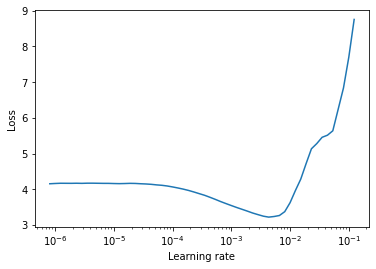

In [18]:
lr_finder.plot()# best lr is in b/w 0.009 and 0.1

In [0]:
lr_finder.reset()

In [0]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self, model, device, optimizer, criterion):


    self.model = model
    self.device = device
    self.optimizer = optimizer
    self.criterion = criterion

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, trainloader, epoch, L1lambda=None):
    self.model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(self.device), target.to(self.device)
      self.optimizer.zero_grad()    # clear the gradients of all optimized variables

      # Predict
      y_pred = self.model(data)   # forward pass

      # Calculate loss
      c_loss = self.criterion(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.
          for param in self.model.parameters():
            l1_loss += torch.sum(param.abs())
          loss = c_loss +  (L1lambda * l1_loss)



      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      self.optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm

      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    self.train_acc.append(100*correct/processed)
      # scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])
    self.train_losses.append(loss)


  def test(self, testloader, filename, correct_samples, correctLabels, incorrect_samples):
      self.model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(self.device), target.to(self.device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_loss = self.criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))
            # scheduler.step()

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam



      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(self.model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))


      self.test_acc.append(100. * correct / len(testloader.dataset))
      self.test_losses.append(test_loss)



def cross_entropy_loss():
    """Returns:
        Cross entroy loss function
    """
    return torch.nn.CrossEntropyLoss()

def model_summary(model, input_size=(3,32,32)):
  """
  Returns Summary of the model passed in as model
  """
  return summary(model, input_size)


**Modelling**

In [35]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = main11().to(device)

criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 5e-2, momentum=0.9, weight_decay=1e-4, nesterov = True) 
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', threshold_mode = "abs", patience=2, factor = 0.9, verbose=True)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 5e-2, epochs = 24, steps_per_epoch=len(trainLoader))

model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 24


for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  # scheduler.step(model1.test_losses[-1])
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = param_group['lr'], e=epoch+1))

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH:  1


Loss=2.034822940826416 Batch_id=97 Accuracy=36.06: 100%|██████████| 98/98 [00:17<00:00,  5.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.3683).  Saving model ...

Test set: Average loss: 1.3683, Accuracy: 4921/10000 (49.21%)

Learning Rate = 0.0020000000000000018 for EPOCH 2
EPOCH:  2


Loss=1.8474297523498535 Batch_id=97 Accuracy=50.87: 100%|██████████| 98/98 [00:17<00:00,  5.62it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.3683 --> 1.2594).  Saving model ...

Test set: Average loss: 1.2594, Accuracy: 5535/10000 (55.35%)

Learning Rate = 0.0020000000000000018 for EPOCH 3
EPOCH:  3


Loss=1.718947172164917 Batch_id=97 Accuracy=58.38: 100%|██████████| 98/98 [00:17<00:00,  5.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.2594 --> 1.1847).  Saving model ...

Test set: Average loss: 1.1847, Accuracy: 6119/10000 (61.19%)

Learning Rate = 0.0020000000000000018 for EPOCH 4
EPOCH:  4


Loss=1.5009310245513916 Batch_id=97 Accuracy=63.16: 100%|██████████| 98/98 [00:17<00:00,  5.66it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.1847 --> 0.9983).  Saving model ...

Test set: Average loss: 0.9983, Accuracy: 6659/10000 (66.59%)

Learning Rate = 0.0020000000000000018 for EPOCH 5
EPOCH:  5


Loss=1.4037964344024658 Batch_id=97 Accuracy=66.60: 100%|██████████| 98/98 [00:17<00:00,  5.67it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.9983 --> 0.9039).  Saving model ...

Test set: Average loss: 0.9039, Accuracy: 6982/10000 (69.82%)

Learning Rate = 0.0020000000000000018 for EPOCH 6
EPOCH:  6


Loss=1.2816760540008545 Batch_id=97 Accuracy=69.66: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.9039 --> 0.7211).  Saving model ...

Test set: Average loss: 0.7211, Accuracy: 7248/10000 (72.48%)

Learning Rate = 0.0020000000000000018 for EPOCH 7
EPOCH:  7


Loss=1.3708466291427612 Batch_id=97 Accuracy=72.76: 100%|██████████| 98/98 [00:17<00:00,  5.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7626, Accuracy: 7343/10000 (73.43%)

Learning Rate = 0.0020000000000000018 for EPOCH 8
EPOCH:  8


Loss=1.2955031394958496 Batch_id=97 Accuracy=74.45: 100%|██████████| 98/98 [00:17<00:00,  5.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.7211 --> 0.7189).  Saving model ...

Test set: Average loss: 0.7189, Accuracy: 7641/10000 (76.41%)

Learning Rate = 0.0020000000000000018 for EPOCH 9
EPOCH:  9


Loss=1.1925143003463745 Batch_id=97 Accuracy=76.22: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.7189 --> 0.5430).  Saving model ...

Test set: Average loss: 0.5430, Accuracy: 7710/10000 (77.10%)

Learning Rate = 0.0020000000000000018 for EPOCH 10
EPOCH:  10


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7609, Accuracy: 7805/10000 (78.05%)

Learning Rate = 0.0020000000000000018 for EPOCH 11
EPOCH:  11


Loss=1.2063835859298706 Batch_id=97 Accuracy=78.97: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7407, Accuracy: 7815/10000 (78.15%)

Learning Rate = 0.0020000000000000018 for EPOCH 12
EPOCH:  12


Loss=1.1906472444534302 Batch_id=97 Accuracy=79.96: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5576, Accuracy: 7924/10000 (79.24%)

Learning Rate = 0.0020000000000000018 for EPOCH 13
EPOCH:  13


Loss=1.082170009613037 Batch_id=97 Accuracy=81.30: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6864, Accuracy: 8049/10000 (80.49%)

Learning Rate = 0.0020000000000000018 for EPOCH 14
EPOCH:  14


Loss=1.060464859008789 Batch_id=97 Accuracy=82.16: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.5430 --> 0.5286).  Saving model ...

Test set: Average loss: 0.5286, Accuracy: 8116/10000 (81.16%)

Learning Rate = 0.0020000000000000018 for EPOCH 15
EPOCH:  15


Loss=1.0574584007263184 Batch_id=97 Accuracy=82.95: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.5286 --> 0.4719).  Saving model ...

Test set: Average loss: 0.4719, Accuracy: 8117/10000 (81.17%)

Learning Rate = 0.0020000000000000018 for EPOCH 16
EPOCH:  16


Loss=1.0568411350250244 Batch_id=97 Accuracy=83.82: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.4719 --> 0.4528).  Saving model ...

Test set: Average loss: 0.4528, Accuracy: 8214/10000 (82.14%)

Learning Rate = 0.0020000000000000018 for EPOCH 17
EPOCH:  17


Loss=1.0495171546936035 Batch_id=97 Accuracy=84.70: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.4528 --> 0.4423).  Saving model ...

Test set: Average loss: 0.4423, Accuracy: 8266/10000 (82.66%)

Learning Rate = 0.0020000000000000018 for EPOCH 18
EPOCH:  18


Loss=1.0334030389785767 Batch_id=97 Accuracy=85.47: 100%|██████████| 98/98 [00:17<00:00,  5.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5257, Accuracy: 8148/10000 (81.48%)

Learning Rate = 0.0020000000000000018 for EPOCH 19
EPOCH:  19


Loss=0.9481821656227112 Batch_id=97 Accuracy=86.16: 100%|██████████| 98/98 [00:17<00:00,  5.70it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6346, Accuracy: 8278/10000 (82.78%)

Learning Rate = 0.0020000000000000018 for EPOCH 20
EPOCH:  20


Loss=0.9522776007652283 Batch_id=97 Accuracy=86.51: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5312, Accuracy: 8303/10000 (83.03%)

Learning Rate = 0.0020000000000000018 for EPOCH 21
EPOCH:  21


Loss=0.858757495880127 Batch_id=97 Accuracy=86.87: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5548, Accuracy: 8392/10000 (83.92%)

Learning Rate = 0.0020000000000000018 for EPOCH 22
EPOCH:  22


Loss=0.8653401136398315 Batch_id=97 Accuracy=87.74: 100%|██████████| 98/98 [00:17<00:00,  5.75it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6615, Accuracy: 8145/10000 (81.45%)

Learning Rate = 0.0020000000000000018 for EPOCH 23
EPOCH:  23


Loss=0.9326158761978149 Batch_id=97 Accuracy=88.30: 100%|██████████| 98/98 [00:17<00:00,  5.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5246, Accuracy: 8427/10000 (84.27%)

Learning Rate = 0.0020000000000000018 for EPOCH 24
EPOCH:  24


Loss=0.899276852607727 Batch_id=97 Accuracy=88.42: 100%|██████████| 98/98 [00:17<00:00,  5.76it/s]


Validation loss has  decreased (0.4423 --> 0.4086).  Saving model ...

Test set: Average loss: 0.4086, Accuracy: 8423/10000 (84.23%)

Learning Rate = 0.0020000000000000018 for EPOCH 25


**Cyclic LR**

[0.0001, 0.00010918367346938767, 0.00011836734693877553, 0.0001275510204081632, 0.00013673469387755107, 0.00014591836734693874, 0.0001551020408163266, 0.00016428571428571425, 0.00017346938775510213, 0.0001826530612244898, 0.00019183673469387746, 0.00020102040816326534, 0.00021020408163265297, 0.00021938775510204085, 0.0002285714285714285, 0.00023775510204081636, 0.00024693877551020405, 0.0002561224489795919, 0.0002653061224489796, 0.00027448979591836723, 0.0002836734693877551, 0.0002928571428571428, 0.0003020408163265306, 0.0003112244897959183, 0.00032040816326530617, 0.00032959183673469386, 0.0003387755102040817, 0.00034795918367346934, 0.00035714285714285703, 0.0003663265306122449, 0.00037551020408163274, 0.00038469387755102043, 0.00039387755102040806, 0.0004030612244897959, 0.0004122448979591836, 0.00042142857142857146, 0.00043061224489795915, 0.0004397959183673468, 0.0004489795918367347, 0.00045816326530612254, 0.0004673469387755102, 0.00047653061224489787, 0.0004857142857142857, 0

98

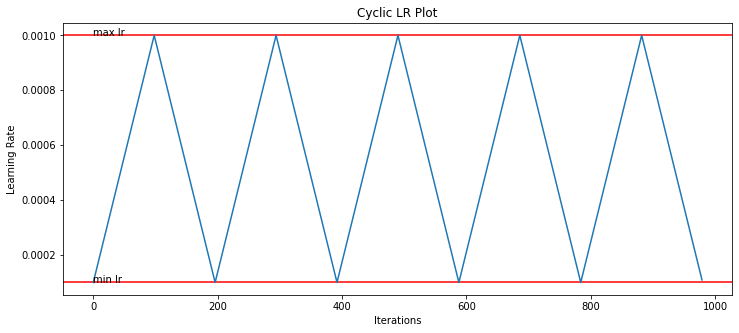

In [48]:
class CLR:
  def __init__(self, max_lr, min_lr, stepsize, num_iterations):
    self.max_lr = max_lr
    self.min_lr = min_lr
    self.stepsize = stepsize
    self.iterations = num_iterations
    self.lr_list = []

  def cycle(self, iteration):
    return int(1 + (iteration/(2*self.stepsize)))

  def lr_position(self, iteration, cycle):
    return abs(iteration/self.stepsize - (2*cycle) + 1)

  def current_lr(self, lr_position):
    return self.min_lr + (self.max_lr - self.min_lr)*(1-lr_position)
  
  def cyclic_lr(self, plotGraph = True):
    for i in range(self.iterations):
      # print('i', i)
      cycle = self.cycle(i)
      # print('cycle', cycle)
      lr_position = self.lr_position(i, cycle)
      # print('lr position', lr_position)
      current_lr = self.current_lr(lr_position)
      # print('current_lr', round(current_lr,6))
      self.lr_list.append(current_lr)
    
    if plotGraph:
      fig = plt.figure(figsize=(12,5))
      
      #Plot Title
      plt.title('Cyclic LR Plot')

      plt.xlabel('Iterations')
      plt.ylabel('Learning Rate')

      plt.axhline(y=self.min_lr, label='min lr', color='r')
      plt.text(0, self.min_lr, 'min lr')

      plt.axhline(y=self.max_lr, label='max lr', color='r')
      plt.text(0, self.max_lr, 'max lr')

      plt.plot(self.lr_list)
      print(self.lr_list)



clr1 = CLR(0.001, 0.0001, len(trainLoader), len(trainLoader)*10)
clr1.cyclic_lr(plotGraph=True)







**Plot Train & Test Curves**

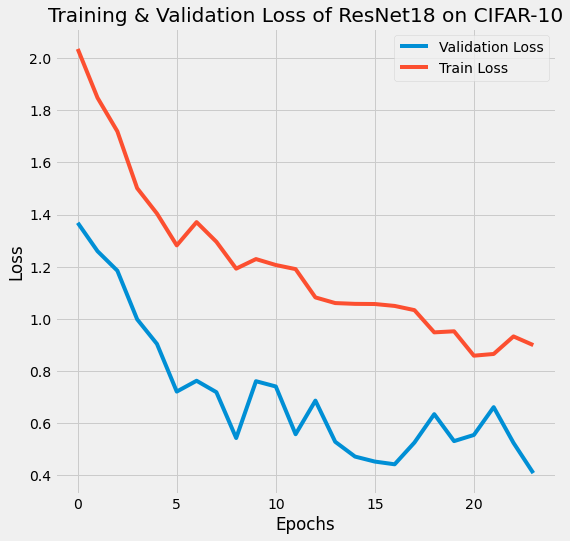

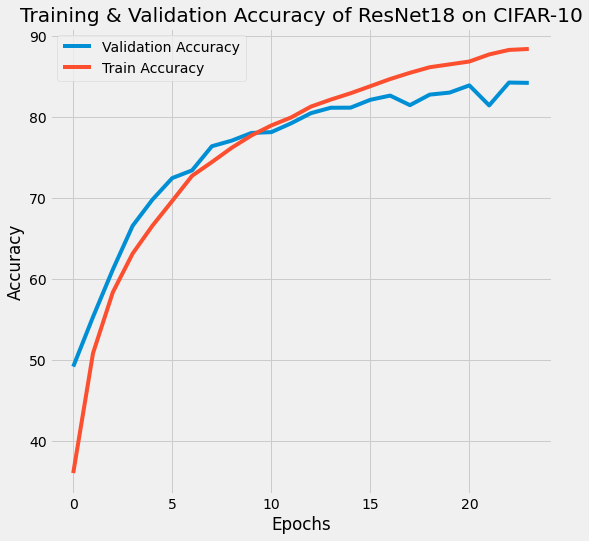

In [49]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Misclassified Images**

<Figure size 936x936 with 0 Axes>

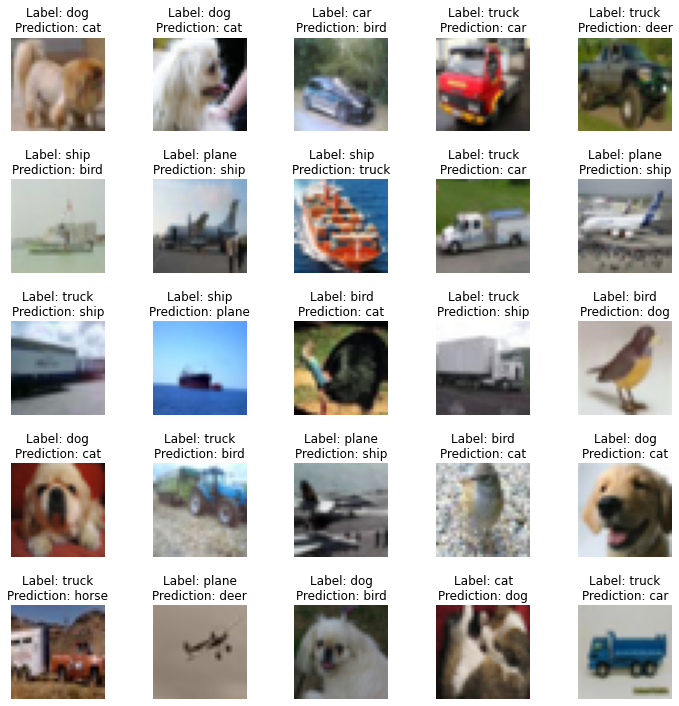

In [52]:
display.misclassified_ones(model, testLoader, incorrectSamples,'MisclassfiedOnes.png')

#GradCam Implementation

**GradCam Input Data**

In [0]:
images = [x['image'] for x in incorrectSamples[10:35]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:35]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:35]] # Predicted Classes
targetLabels = [classes[t] for t in target_classes] # Target Labels
predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


In [0]:
from torch.nn import functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

class GradCAM():
    """ Helper Class for extracting activations and
    registering gradients from target(intermediate) layers
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
          def forward_hook(module, input, output): # this will return Input & Output of  a layer during Forward Pass
              self.fmap_pool[key] = output.detach() #

          return forward_hook

        def save_grads(key):
          def backward_hook(module, grad_in, grad_out): # this will return Input & Output of a layer during Backward Pass
              self.grad_pool[key] = grad_out[0].detach() #

          return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name))) # appending I/P & O/P of a layer during forward pass
                self.handlers.append(module.register_backward_hook(save_grads(name))) # same during backward pass

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)  # creating a one hot tensor of self.nll shape, but filled with zeros
        print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0) # replacing ids with 1.0 at dim = 1
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size duign forward pass
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam





def GRADCAM(images, device, labels, model, target_layers):
  model.eval()
  # map input to device
  images = torch.stack(images).to(device)
  # set up grad cam
  gcam = GradCAM(model, target_layers)
  # forward pass
  probs, ids = gcam.forward(images)
  # outputs agaist which to compute gradients
  ids_ = torch.LongTensor(labels).view(len(images),-1).to(device)
  # backward pass
  gcam.backward(ids=ids_)
  layers = []
  for i in range(len(target_layers)):
    target_layer = target_layers[i]
    print("Generating Grad-CAM @{}".format(target_layer))
    # Grad-CAM
    layers.append(gcam.generate(target_layer=target_layer))
  # remove hooks when done
  gcam.remove_hook()
  return layers, probs, ids



def PLOT(gcam_layers, images, target_layers, image_size, unnormalize, tc, pc):
    """
    ***Arguments***:
    gcam_layers:
    images: set of images(both correctly classified and misclassified)
    target_layers: set of layers where you want to plot GradCAM
    image_size: size of image
    unnormalize: de/unnormalizing the image
    tc: actual/target class labels
    pc: predicted class labels
    """

    c = len(images)+1
    r = len(target_layers)+2
    fig = plt.figure(figsize=(30,32))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=12)
    plt.axis('off')
    for i in range(len(target_layers)):
      target_layer = target_layers[i]
      ax = plt.subplot(r, c, c*(i+1)+1)
      ax.text(0.3,-0.5, target_layer, fontsize=12)
      plt.axis('off')
      

      for j in range(len(images)):
        img = np.uint8(255*unnormalize(images[j].view(image_size)))
        if i==0:
          ax = plt.subplot(r, c, j+2)
          ax.text(0, 0.2, f'pred={pc[j]}\nactual={tc[j]}', fontsize=10)
          plt.axis('off')
          plt.subplot(r, c, c+j+2)
          plt.imshow(img, interpolation='bilinear')
          plt.axis('off')


        heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
        plt.subplot(r, c, (i+2)*c+j+2)
        plt.imshow(superimposed_img, interpolation='bilinear')

        plt.axis('off')
    plt.show()


**GradCam Core** 

In [0]:
model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
print('IMPLEMENTING GRADCAM FOR SET1[...]')
gradcam_output, probs, predicted_classes = GRADCAM(images, device, target_classes, model, target_layers) 
#gdc.
PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
